# Generating N-model data

In the previous tutorial, we constructed the Exponential distribution class using the `BaseDistribution` class. As a quick recap,

1. The `BaseDistribution` class has three functions, **pdf**, **cdf**, and **stats**.
2. The API requires a **normalize** keyword when defining the class.
3. It is better to have **PDF** and **CDF** functions separate than the class.

In this tutorial, we'll focus on the `generators` module, which helps to generate an N-model distribution over an x array.
Just like the `BaseDistribution` template class, the `generators` module provides a `multi_base` function that enables a custom distribution class to be utilized as an N-model generator.

## `multi_base`

The function accepts five arguments,

1. `x`: The array of values on which the distributions are to be generated,
2. `distribution_func`: A class/subclass of `BaseDistribution`,
3. `params`: List of tuples containing the parameters for the required distribution,
4. `noise_level`: Standard deviation of the noise to be added to the data, and
5. `normalize`: Whether to normalize the distribution or not.

Let's use `multi_base` to generate the three exponential distributions that we did in the last tutorial with $\lambda \in [0.5, 1, 1.5]$.

## Example 1: Single parameter distribution

Let's setup our exponential distribution again, but this time using the internal `BaseDistribution`.

In [1]:
import numpy as np

from pymultifit.distributions.backend import BaseDistribution


def exp_pdf(x, lambda_, normalize: bool = False):
    """Exponential PDF."""
    return lambda_ * np.exp(-lambda_ * x)


def exp_cdf(x, lambda_, normalize: bool = False):
    """Exponential CDF."""
    return 1 - np.exp(-lambda_ * x)


class Exponential(BaseDistribution):
    """Mock Exponential distribution."""

    def __init__(self, lambda_: float = 1.0, normalize: bool = True):
        self.lambda_ = lambda_

        self.norm = normalize

    def pdf(self, x):
        return exp_pdf(x, self.lambda_, self.norm)

    def cdf(self, x):
        return exp_cdf(x, self.lambda_, self.norm)

    def stats(self):
        return {'mean': 1 / self.lambda_}

With the distributions set, we can now generate our three exponentials easily.
Let's define the x-array and distribution parameters.
In the case of our exponential distribution, we only need one parameter, $\lambda$.

<div style="border-left: 10px solid #2196F3; background-color: #f1f1f1; padding: 15px;">
    <strong>Note:</strong> Although in this example the parameters are passed as <strong>list of floats</strong> instead of the intended <strong>list of tuples of floats</strong> this is because the distribution only requires a single parameter. This will not work with distributions using multiple parameters, as will be demonstrated in the next example.
</div>

In [2]:
x = np.linspace(0, 10, 5_000)
parameters = [0.5, 1.0, 1.5]

The parameters for the distribution **should** always be passed as a tuple of parameters, even if it is a single parameter.
The `normalize` parameter is not to be included in the list of parameters here.
Let's also add a small, $\mathcal{N}(0, 0.1)$ noise to the data.

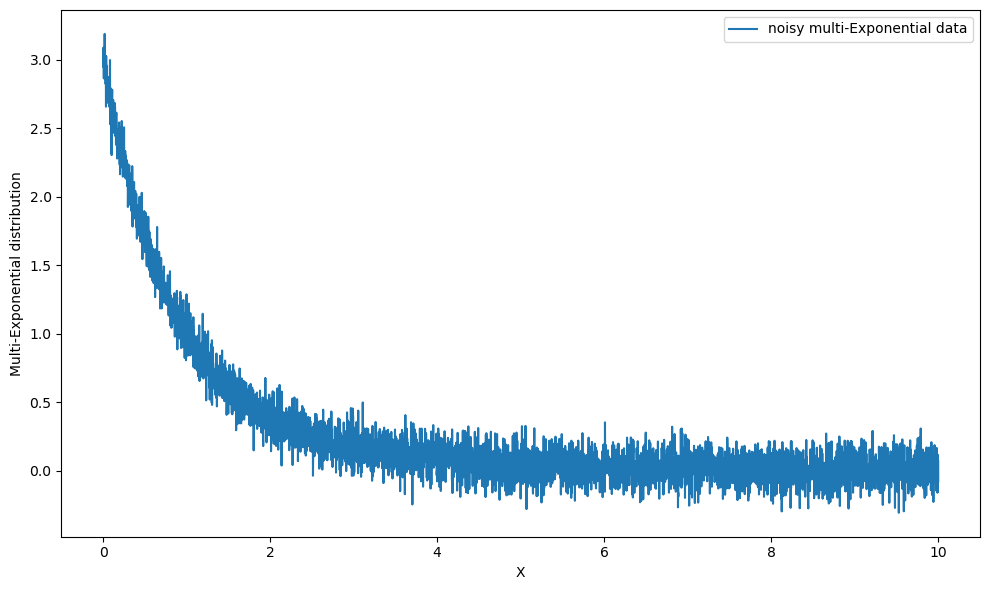

In [3]:
import matplotlib.pyplot as plt
from pymultifit.generators import multi_base

y_multi_expon = multi_base(x,
                           distribution_func=Exponential, params=parameters, noise_level=0.1)

plt.figure(figsize=(10, 6))
plt.plot(x, y_multi_expon, label='noisy multi-Exponential data')
plt.xlabel('X')
plt.ylabel('Multi-Exponential distribution')
plt.legend()
plt.tight_layout()
plt.show()

Let's compare this with our regular three distributions,

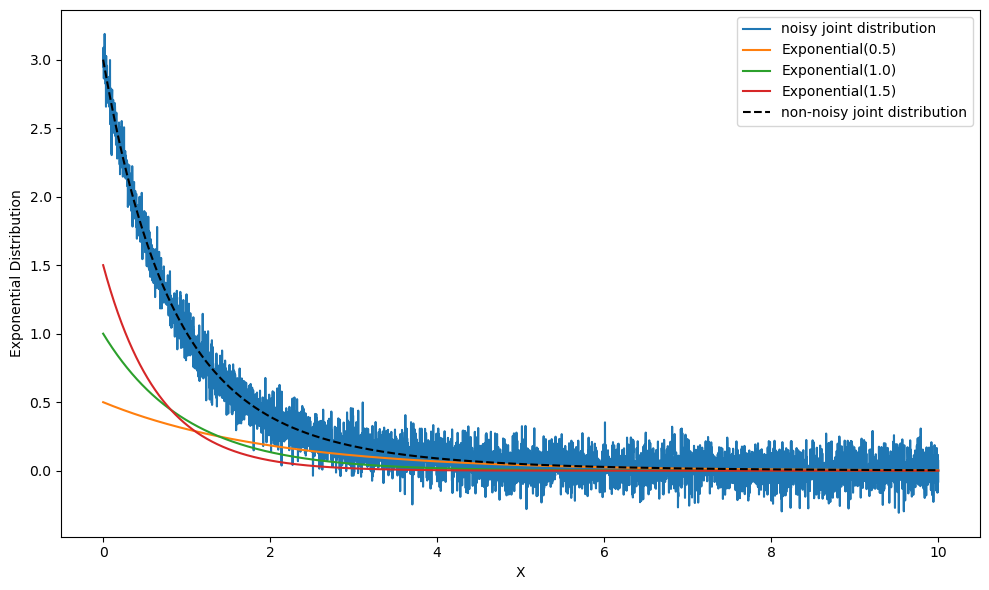

In [4]:
exp1 = Exponential(0.5).pdf(x)
exp2 = Exponential(1).pdf(x)
exp3 = Exponential(1.5).pdf(x)

y_expon_sum = exp1 + exp2 + exp3

plt.figure(figsize=(10, 6))
plt.plot(x, y_multi_expon, label='noisy joint distribution')
plt.plot(x, exp1, label='Exponential(0.5)')
plt.plot(x, exp2, label='Exponential(1.0)')
plt.plot(x, exp3, label='Exponential(1.5)')
plt.plot(x, y_expon_sum, 'k--', label='non-noisy joint distribution')

plt.xlabel('X')
plt.ylabel('Exponential Distribution')
plt.legend()
plt.tight_layout()
plt.show()

Fantastic work!

## Example 2: Multi-parameter Distribution

We worked with exponential distribution; now let's model **Gaussian** distribution with parameters $\mu$ and $\sigma$.

In [5]:
from scipy.special import erf


def gauss_pdf(x_,
              mu: float = 0.0, sigma: float = 1.0, normalize: bool = False):
    """Gaussian PDF."""
    exponent = -0.5 * ((x_ - mu) / sigma)**2
    fraction = np.sqrt(2 * np.pi * sigma**2)

    return np.exp(exponent) / fraction


def gauss_cdf(x_,
              mu: float = 0.0, sigma: float = 1.0, normalize: bool = False):
    """Gaussian CDF."""
    num_ = x_ - mu
    den_ = sigma * np.sqrt(2)
    return 0.5 * (1 + erf(num_ / den_))


class Gaussian(BaseDistribution):
    """Mock Gaussian distribution."""

    def __init__(self,
                 mu: float = 0.0, sigma: float = 1.0,
                 normalize: bool = False):
        self.mu = mu
        self.sigma = sigma
        self.norm = normalize

    def pdf(self, x_):
        return gauss_pdf(x_, mu=self.mu, sigma=self.sigma, normalize=self.norm)

    def cdf(self, x_):
        return gauss_cdf(x_, mu=self.mu, sigma=self.sigma, normalize=self.norm)

    def stats(self):
        return {'mean': self.mu}

Let's generate five gaussian distributions with $\mu \in [1, 4, 5, 7.5, 9]$ and $\sigma \in [0.3, 1, 1.2, 1.5, 0.1]$ using `multi_base`.

In [6]:
parameters = [(1, 0.3), (4, 1), (5, 1.2), (7.5, 1.5), (9, 0.1)]

The parameters will always follow the order of the parameters defined in the distribution; in this case, the order of parameters is $(\mu, \sigma)$.
Notice the use of tuples here. The parameters are defined in tuples to keep relevant distributions together.

In case you have lists of parameters separately, you can use `np.column_stack` to reform the lists into a single parsable stack.

In [7]:
mean_list = [1, 4, 5, 7.5, 9]
sigma_list = [0.3, 1, 1.2, 1.5, 0.1]

parameters_stacked = np.column_stack([mean_list, sigma_list])

In [8]:
y_gaussian = multi_base(x,
                        distribution_func=Gaussian,
                        params=parameters,
                        noise_level=0.1)

y_gaussian_stacked = multi_base(x,
                                distribution_func=Gaussian,
                                params=parameters_stacked,
                                noise_level=0.1)

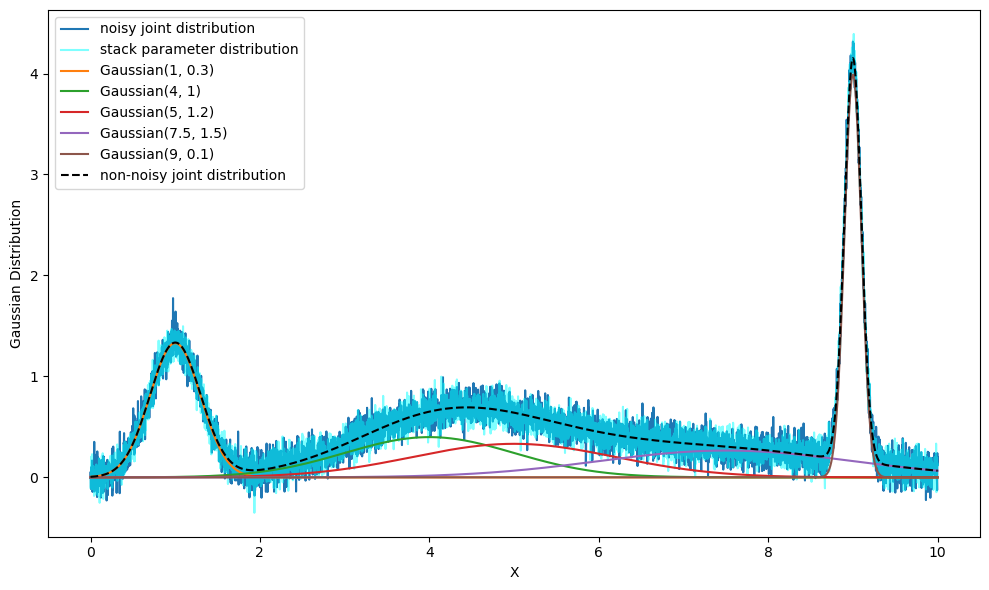

In [9]:
gaussian_distributions = []

for param in parameters:
    gaussian_distributions.append(Gaussian(mu=param[0], sigma=param[1]).pdf(x))

y_gaussian_sum = np.sum(gaussian_distributions, axis=0)

plt.figure(figsize=(10, 6))

# multi-gaussian
plt.plot(x, y_gaussian, label='noisy joint distribution')

# multi-gaussian using stacked parameters
plt.plot(x, y_gaussian_stacked, 'cyan', alpha=0.5, label='stack parameter distribution')

# individual gaussian distributions
plt.plot(x, gaussian_distributions[0], label='Gaussian(1, 0.3)')
plt.plot(x, gaussian_distributions[1], label='Gaussian(4, 1)')
plt.plot(x, gaussian_distributions[2], label='Gaussian(5, 1.2)')
plt.plot(x, gaussian_distributions[3], label='Gaussian(7.5, 1.5)')
plt.plot(x, gaussian_distributions[4], label='Gaussian(9, 0.1)')

# summed gaussian distribution
plt.plot(x, y_gaussian_sum, 'k--', label='non-noisy joint distribution')

plt.xlabel('X')
plt.ylabel('Gaussian Distribution')
plt.legend()
plt.tight_layout()
plt.show()

And that's how you generate multi-distribution data using `pyMultiFit`.